In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")


In [2]:
import yfinance as yf
import pandas as pd

In [3]:
sp500=yf.download('SPY')

[*********************100%%**********************]  1 of 1 completed


In [4]:
sp500.index = pd.to_datetime(sp500.index)

In [5]:
sp500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.608629,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,24.783655,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,24.836163,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.098698,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.203705,531500
...,...,...,...,...,...,...
2024-10-21,583.849976,584.849976,580.599976,583.630005,583.630005,36439000
2024-10-22,581.049988,584.500000,580.380005,583.320007,583.320007,34183800
2024-10-23,581.260010,581.710022,574.419983,577.989990,577.989990,49314600


<Axes: xlabel='Date'>

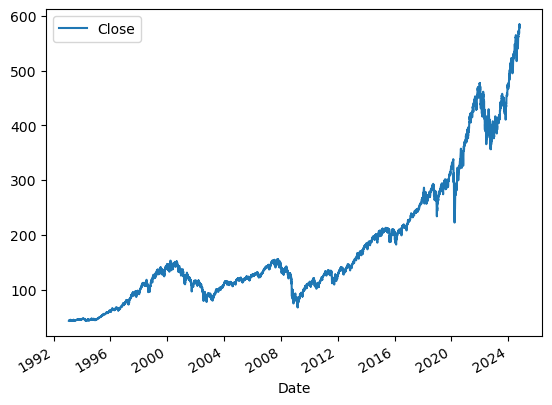

In [6]:
sp500.plot.line(y="Close", use_index=True)

In [7]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [8]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [9]:
sp500 = sp500.loc["1990-01-01":].copy()

In [10]:
close_data = sp500.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)


7594


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sp500)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [12]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.summary


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x0000020152617B80>>

In [14]:
model.compile(optimizer='adam',
			loss='mean_squared_error')
history = model.fit(x_train,
					y_train,
					epochs=10)


Epoch 1/10
236/236 [==============================] - 52s 148ms/step - loss: 0.0020
Epoch 2/10
236/236 [==============================] - 35s 146ms/step - loss: 1.7792e-04
Epoch 3/10
236/236 [==============================] - 36s 151ms/step - loss: 1.6268e-04
Epoch 4/10
236/236 [==============================] - 33s 138ms/step - loss: 1.6744e-04
Epoch 5/10
236/236 [==============================] - 33s 140ms/step - loss: 1.2786e-04
Epoch 6/10
236/236 [==============================] - 34s 143ms/step - loss: 1.1320e-04
Epoch 7/10
236/236 [==============================] - 33s 139ms/step - loss: 9.2344e-05
Epoch 8/10
236/236 [==============================] - 35s 149ms/step - loss: 8.7955e-05
Epoch 9/10
236/236 [==============================] - 37s 155ms/step - loss: 1.3454e-04
Epoch 10/10
236/236 [==============================] - 36s 152ms/step - loss: 8.4188e-05


In [19]:
# Fit the scaler on the 'Close' column only
close_data = sp500[['Close']]  # Select only the Close column for scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

# Proceed with your existing code after this point
# Ensure any `inverse_transform` calls only apply to predictions in the Close column context

# Example for predictions:
predictions = model.predict(x_test)
if len(predictions.shape) == 1:
    predictions = predictions.reshape(-1, 1)  # Ensure predictions have the correct shape

# Inverse transform
predictions = scaler.inverse_transform(predictions)  # This should now work without error


13/13 [==============================] - 1s 42ms/step


In [27]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test_mean = np.mean(y_test[np.isfinite(y_test).all(axis=1)])

# Replace missing values in y_test with mean
y_test_filled = y_test.copy()
y_test_filled[np.isnan(y_test_filled)] = y_test_mean
y_test_filled[np.isinf(y_test_filled)] = y_test_mean
# Predict the testing data
predictions = model.predict(x_test)

# Reshape predictions before inverse transformation
predictions = np.reshape(predictions, (predictions.shape[0], 1))  # Fix the shape mismatch

# Inverse transform predictions
predictions = scaler.inverse_transform(predictions)

# Evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))


13/13 [==============================] - 1s 53ms/step
MSE nan
RMSE nan


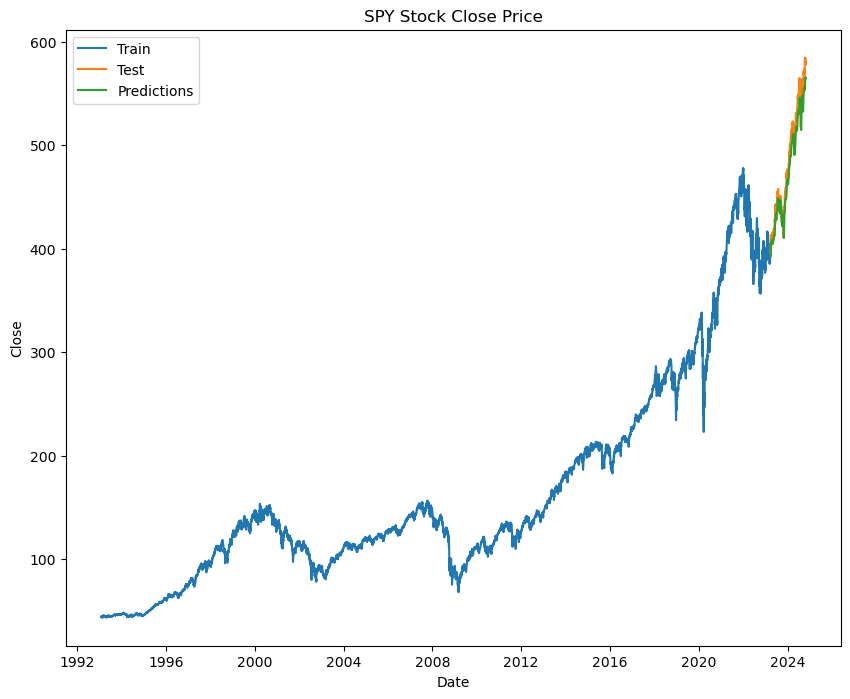

In [28]:
train = sp500[:training]
test = sp500[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot( train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.title('SPY Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
